# PT Denki Kobo Sales Prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import math
import glob
from datetime import datetime

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [2]:
# load and concatenate all sales data
train_data_path = glob.glob('IOD/Train/*.csv')
test_data_path = glob.glob('IOD/Test/*.csv')
df_train = pd.concat(pd.read_csv(file) for file in train_data_path)
df_test = pd.concat(pd.read_csv(file) for file in test_data_path)
df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130752 entries, 0 to 130751
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   index       130752 non-null  int64  
 1   Date        130752 non-null  object 
 2   Category1   130752 non-null  object 
 3   Category2   90361 non-null   object 
 4   Category3   29712 non-null   object 
 5   Maker       130752 non-null  object 
 6   Sales       125543 non-null  float64
 7   Identifier  130752 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 8.0+ MB


In [4]:
# determine if sales is from Denki Kobo or not
# sales belonging to Denki Kobo is identifiable by the Identifier full of alphabet (no numeric)
df_train['is_DK'] =  df_train['Identifier'].str.isalpha()
df_test['is_DK'] =  df_test['Identifier'].str.isalpha()

In [5]:
# filter the sales data only for Denki Kobo
df_dk_train = df_train[df_train['is_DK'] == True]
df_dk_test = df_test[df_test['is_DK'] == True]
# df_dk_train.info()

In [6]:
# convert Date column Dtype to Datetime
df_dk_train['Date'] = pd.to_datetime(df_dk_train['Date'], format='%Y-%m-%d')
df_dk_test['Date'] = pd.to_datetime(df_dk_test['Date'], format='%Y-%m-%d')

<ipython-input-6-84aac2c9751e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dk_train['Date'] = pd.to_datetime(df_dk_train['Date'], format='%Y-%m-%d')
<ipython-input-6-84aac2c9751e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dk_test['Date'] = pd.to_datetime(df_dk_test['Date'], format='%Y-%m-%d')


In [7]:
df_dk_train['Day'] = df_dk_train['Date'].dt.day
df_dk_train['Month'] = df_dk_train['Date'].dt.month
df_dk_train['Year'] = df_dk_train['Date'].dt.year

df_dk_test['Day'] = df_dk_test['Date'].dt.day
df_dk_test['Month'] = df_dk_test['Date'].dt.month
df_dk_test['Year'] = df_dk_test['Date'].dt.year

<ipython-input-7-7c2146dccd60>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dk_train['Day'] = df_dk_train['Date'].dt.day
<ipython-input-7-7c2146dccd60>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dk_train['Month'] = df_dk_train['Date'].dt.month
<ipython-input-7-7c2146dccd60>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

In [8]:
# create a new column to store full category name
df_dk_train['Category'] = (df_dk_train['Category1'].fillna('') + ' ' + df_dk_train['Category2'].fillna('') + ' ' + df_dk_train['Category3'].fillna('')).str.strip()
df_dk_test['Category'] = (df_dk_test['Category1'].fillna('') + ' ' + df_dk_test['Category2'].fillna('') + ' ' + df_dk_test['Category3'].fillna('')).str.strip()

<ipython-input-8-934a0f51ef47>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dk_train['Category'] = (df_dk_train['Category1'].fillna('') + ' ' + df_dk_train['Category2'].fillna('') + ' ' + df_dk_train['Category3'].fillna('')).str.strip()
<ipython-input-8-934a0f51ef47>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dk_test['Category'] = (df_dk_test['Category1'].fillna('') + ' ' + df_dk_test['Category2'].fillna('') + ' ' + df_dk_test['Category3'].fillna('')).str.strip()


In [9]:
# create a dataframe of average sales for each category and maker
df_sales_mean = pd.DataFrame(data=df_dk_train[df_dk_train['Sales'].isna() == False].groupby(by=['Category', 'Maker']).mean()['Sales'])
df_sales_mean['Sales'] = df_sales_mean['Sales'].round().astype(int)
df_sales_mean

Sales
Category         Maker           
Air Conditioners Funami      2351
                 Toshino     5172
                 Yoshikawa   4996
Dishwashers      Katayama    1056
                 Matsumoto    535
                 Nanase      3163
Ovens & Cooktops Ikeda        349
                 Omuro      24827
                 Shimada     1459
                 Sugiura     3296
                 Toshino     2800
Refrigerators    Akaza       1076
                 Funami      1046
                 Nanase       724
                 Omuro      15790
Rice Cookers     Furutani    6838
                 Ikeda       1199
                 Matsumoto   3694
                 Toshino     6548
Televisions      Katayama    1378
                 Kikuma       394
                 Nanase       327
                 Okamoto     1284
                 Shimada     1426
Vacuum Cleaners  Akaza        941
                 Funami      1014
                 Hayashida    428
                 Hisami      1390
Washers & Dryers Akaza       6844
                 Shimada     3121
Water Heaters    Ikeda        687
                 Omuro       1561
                 Sugiura     1720
                 Yoshikawa    372
Water Pumps      Funami     18595
                 Furutani   11412

In [10]:
# function to impute null sales with average number of sales based on categories and maker
def sales_imputer(df):
    result = []
    for i in range(len(df)):
        sales = df[i][0]
        category = df[i][1]
        maker = df[i][2]
        mean = df_sales_mean.loc[category, maker]
        if math.isnan(sales):
            sales = df_sales_mean.loc[category, maker].values[0]
        result.append(sales)
    return result

In [11]:
train_sales_data_to_impute = df_dk_train[['Sales', 'Category', 'Maker']].values
test_sales_data_to_impute = df_dk_test[['Sales', 'Category', 'Maker']].values

train_sales_imputed = sales_imputer(train_sales_data_to_impute)
test_sales_imputed = sales_imputer(test_sales_data_to_impute)

In [12]:
df_dk_train['Sales_imputed'] = train_sales_imputed
df_dk_test['Sales_imputed'] = test_sales_imputed

<ipython-input-12-672fab295970>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dk_train['Sales_imputed'] = train_sales_imputed
<ipython-input-12-672fab295970>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dk_test['Sales_imputed'] = test_sales_imputed


In [13]:
# df_dk_train_sales_per_month = df_dk_train[['Date', 'Sales']]
df_dk_train_sales_per_month = df_dk_train.groupby(['Year', 'Month']).sum()
df_dk_train_sales_per_month.reset_index(inplace=True)
df_dk_train_sales_per_month['Date'] = pd.to_datetime((df_dk_train_sales_per_month['Year'].astype(str) + '-' + df_dk_train_sales_per_month['Month'].astype(str)), format='%Y-%m-%d')

# df_dk_test_sales_per_month = df_dk_test[['Date', 'Sales']]
df_dk_test_sales_per_month = df_dk_test.groupby(['Year', 'Month']).sum()
df_dk_test_sales_per_month.reset_index(inplace=True)
df_dk_test_sales_per_month['Date'] = pd.to_datetime((df_dk_test_sales_per_month['Year'].astype(str) + '-' + df_dk_test_sales_per_month['Month'].astype(str)), format='%Y-%m-%d')

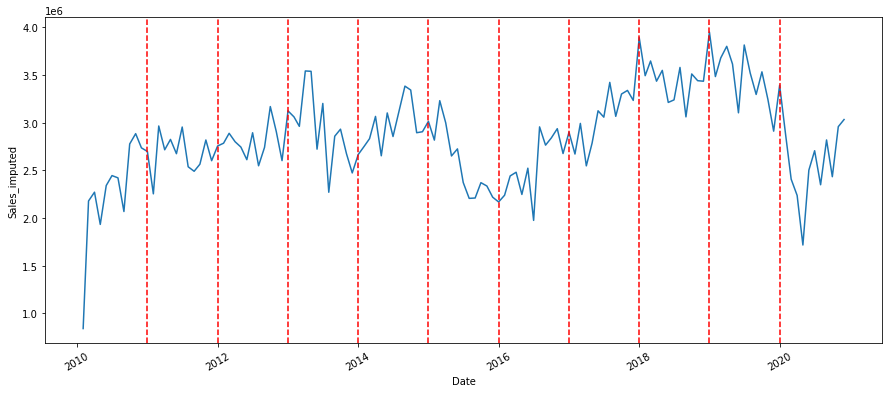

In [14]:
plt.figure(figsize=(15,6))
sns.lineplot(x='Date', y='Sales_imputed', data=df_dk_train_sales_per_month)
plt.xticks(rotation=30);
plt.axvline(pd.to_datetime('2011-01-01'), ls='--', c='red')
plt.axvline(pd.to_datetime('2012-01-01'), ls='--', c='red')
plt.axvline(pd.to_datetime('2013-01-01'), ls='--', c='red')
plt.axvline(pd.to_datetime('2014-01-01'), ls='--', c='red')
plt.axvline(pd.to_datetime('2015-01-01'), ls='--', c='red')
plt.axvline(pd.to_datetime('2016-01-01'), ls='--', c='red')
plt.axvline(pd.to_datetime('2017-01-01'), ls='--', c='red')
plt.axvline(pd.to_datetime('2018-01-01'), ls='--', c='red')
plt.axvline(pd.to_datetime('2019-01-01'), ls='--', c='red')
plt.axvline(pd.to_datetime('2020-01-01'), ls='--', c='red')
# plt.axvline(pd.to_datetime('2021-01-01'), ls='--', c='red')

<AxesSubplot:xlabel='Date'>

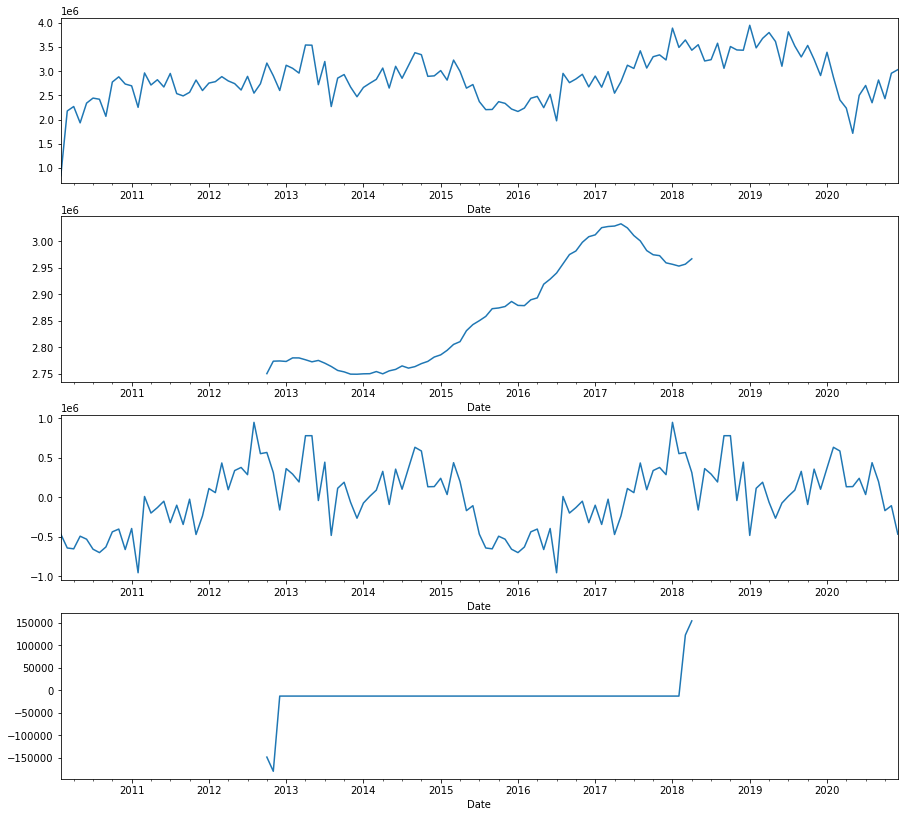

In [15]:
df_dk_train_sales_per_month_indexed = df_dk_train_sales_per_month[['Date', 'Sales_imputed']]
df_dk_train_sales_per_month_indexed = df_dk_train_sales_per_month_indexed.set_index('Date')
df_dk_train_month_decomposed = seasonal_decompose(df_dk_train_sales_per_month_indexed, period=math.floor(len(df_dk_train_sales_per_month_indexed)/2))

fig, ax = plt.subplots(4,1, figsize=(15,14))
df_dk_train_month_decomposed.observed.plot(ax=ax[0])
df_dk_train_month_decomposed.trend.plot(ax=ax[1])
df_dk_train_month_decomposed.seasonal.plot(ax=ax[2])
df_dk_train_month_decomposed.resid.plot(ax=ax[3])

In [16]:
df_dk_train_sales_per_month

,Year,Month,index,Sales,is_DK,Day,Sales_imputed,Date
0,2010,2,53284,761931.0,270,5370,838655.0,2010-02-01
1,2010,3,580355,2041861.0,660,10320,2177783.0,2010-03-01
2,2010,4,290765,2159010.0,630,10530,2269795.0,2010-04-01
3,2010,5,764482,1871576.0,570,9000,1931671.0,2010-05-01
4,2010,6,1480749,2265247.0,660,10110,2339773.0,2010-06-01
...,...,...,...,...,...,...,...,...
126,2020,8,1044075,2206090.0,648,10188,2347921.0,2020-08-01
127,2020,9,2099956,2618753.0,792,12132,2818198.0,2020-09-01
128,2020,10,337434,2299594.0,684,9576,2432367.0,2020-10-01
129,2020,11,1159770,2860413.0,756,11520,2957679.0,2020-11-01


In [17]:
# 1st order diff
df_dk_train_sales_per_month['Sales_lag1'] = df_dk_train_sales_per_month['Sales_imputed'].shift(1)
df_dk_train_sales_per_month['Sales_diff1'] = df_dk_train_sales_per_month['Sales_imputed'] - df_dk_train_sales_per_month['Sales_lag1']

In [18]:
# stationarity check
alpha = 0.05
adfuller_pvalue = adfuller(df_dk_train_sales_per_month['Sales_diff1'].dropna())[1]

if adfuller_pvalue <= alpha:
    print('Reject H0: the data is stationary')
else:
    print('Failed to reject H0: the data is not stationary')

Reject H0: the data is stationary


<AxesSubplot:xlabel='Date', ylabel='Sales_imputed'>

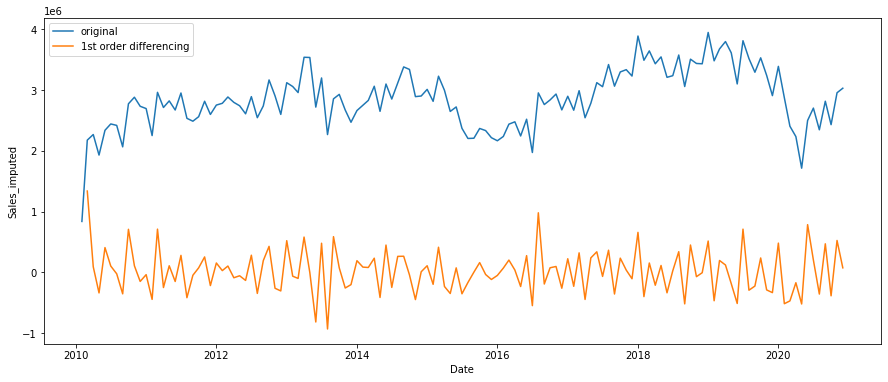

In [19]:
plt.figure(figsize=(15,6))
sns.lineplot(x='Date', y='Sales_imputed', data=df_dk_train_sales_per_month, label='original')
sns.lineplot(x='Date', y='Sales_diff1', data=df_dk_train_sales_per_month, label='1st order differencing')
# sns.lineplot(x='Date', y='Sales_diff2', data=df_dk_sales_per_day, label='2nd order differencing')

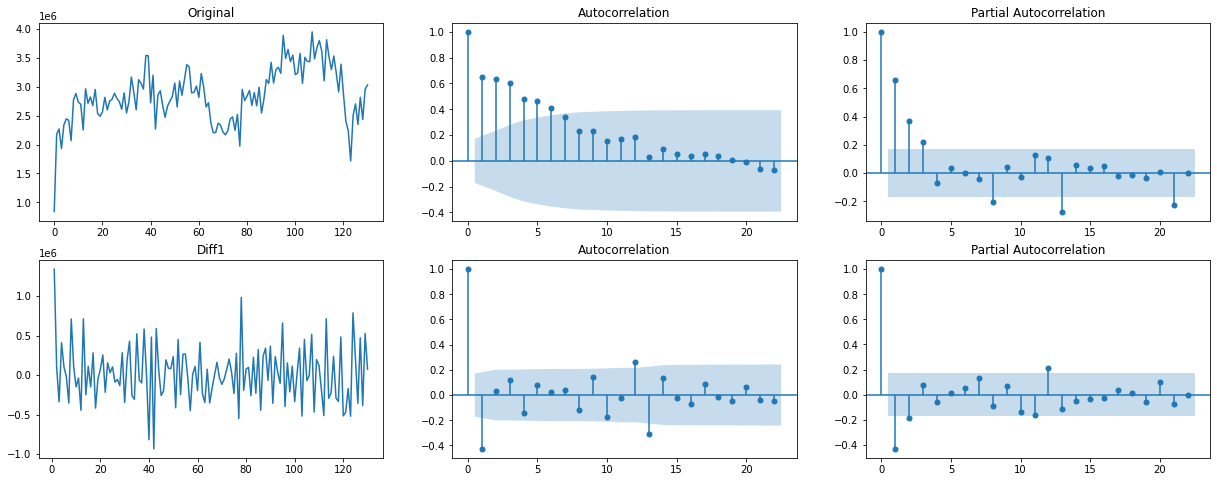

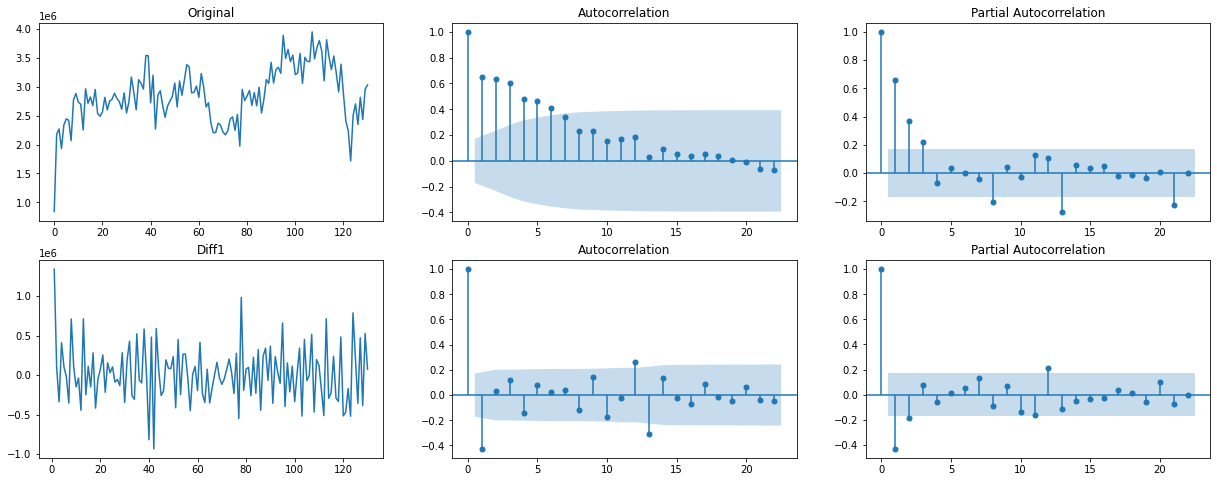

In [20]:
fig, ax = plt.subplots(2, 3, figsize=(21,8))
# original
ax[0, 0].plot(df_dk_train_sales_per_month['Sales_imputed'])
ax[0, 0].set_title('Original')
plot_acf(df_dk_train_sales_per_month['Sales_imputed'], ax=ax[0, 1])
plot_pacf(df_dk_train_sales_per_month['Sales_imputed'], ax=ax[0, 2])
# 1st differencing
ax[1, 0].plot(df_dk_train_sales_per_month['Sales_diff1'])
ax[1, 0].set_title('Diff1')
plot_acf(df_dk_train_sales_per_month['Sales_diff1'].dropna(), ax=ax[1, 1])
plot_pacf(df_dk_train_sales_per_month['Sales_diff1'].dropna(), ax=ax[1, 2])

p: 1
d: 1
q: 2

## Model Training

### ARIMA

In [21]:
arima_model = ARIMA(endog=df_dk_train_sales_per_month['Sales_imputed'], order=(1, 1, 2))
arima_model_fit = arima_model.fit()

print(arima_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:          Sales_imputed   No. Observations:                  131
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -1840.268
Date:                Mon, 17 Oct 2022   AIC                           3688.536
Time:                        16:46:03   BIC                           3700.006
Sample:                             0   HQIC                          3693.197
                                - 131                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7255      0.252      2.875      0.004       0.231       1.220
ma.L1         -1.1390      0.250     -4.549      0.000      -1.630      -0.648
ma.L2          0.3671      0.093      3.947      0.0

<AxesSubplot:xlabel='Date', ylabel='Sales_imputed'>

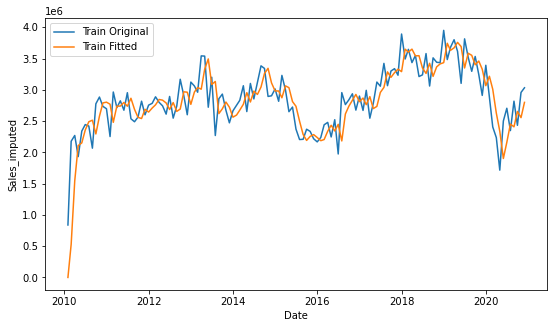

In [22]:
df_dk_train_sales_per_month['sales_fitted'] = arima_model_fit.fittedvalues.values

plt.figure(figsize=(9,5))
sns.lineplot(x='Date', y='Sales_imputed', data=df_dk_train_sales_per_month, label='Train Original')
sns.lineplot(x='Date', y='sales_fitted', data=df_dk_train_sales_per_month, label='Train Fitted')

In [23]:
df_dk_test_sales_per_month_indexed = df_dk_test_sales_per_month.set_index('Date')

#### Testing the model's performance to forecast test data

<AxesSubplot:xlabel='Date', ylabel='Sales_imputed'>

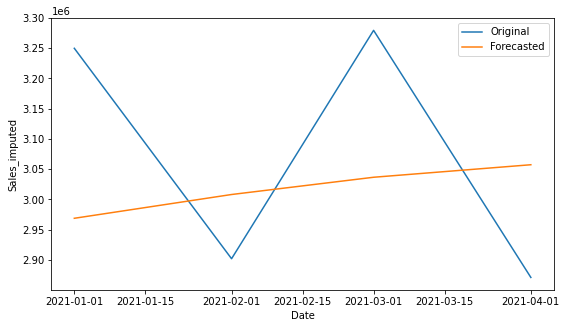

In [24]:
forecast_4mo = arima_model_fit.forecast(4)

plt.figure(figsize=(9,5))
sns.lineplot(x='Date', y='Sales_imputed', data=df_dk_test_sales_per_month_indexed, label='Original')
sns.lineplot(x=df_dk_test_sales_per_month_indexed.index, y=forecast_4mo.values, label='Forecasted')

In [25]:
f = forecast_4mo.values
a = df_dk_test_sales_per_month['Sales_imputed'].values
print('RMSE:', math.sqrt(sum((a-f)**2)))

RMSE: 429373.7582085946


### ARIMA with Exogenous Variable

#### Add 'Quarter' as an exogenous variable

In [26]:
df_dk_train_sales_per_month['Quarter'] = df_dk_train_sales_per_month['Date'].dt.quarter
df_dk_test_sales_per_month['Quarter'] = df_dk_test_sales_per_month['Date'].dt.quarter

In [27]:
arima_model = ARIMA(endog=df_dk_train_sales_per_month['Sales_imputed'], exog=df_dk_train_sales_per_month['Quarter'], order=(1, 1, 2))
arima_model_fit = arima_model.fit()

print(arima_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:          Sales_imputed   No. Observations:                  131
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -1841.129
Date:                Mon, 17 Oct 2022   AIC                           3692.259
Time:                        16:46:04   BIC                           3706.596
Sample:                             0   HQIC                          3698.084
                                - 131                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Quarter    -4.677e+04   2.74e+04     -1.710      0.087      -1e+05    6851.346
ar.L1         -0.8195      0.270     -3.036      0.002      -1.349      -0.290
ma.L1          0.4857      0.268      1.811      0.0

<AxesSubplot:xlabel='Date', ylabel='Sales_imputed'>

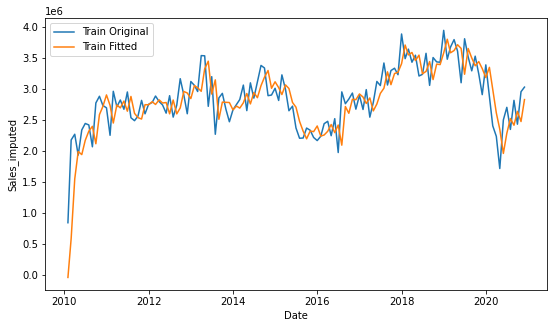

In [28]:
df_dk_train_sales_per_month['sales_fitted'] = arima_model_fit.fittedvalues.values

plt.figure(figsize=(9,5))
sns.lineplot(x='Date', y='Sales_imputed', data=df_dk_train_sales_per_month, label='Train Original')
sns.lineplot(x='Date', y='sales_fitted', data=df_dk_train_sales_per_month, label='Train Fitted')

#### Testing the model's performance to forecast test data

<AxesSubplot:xlabel='Date', ylabel='Sales_imputed'>

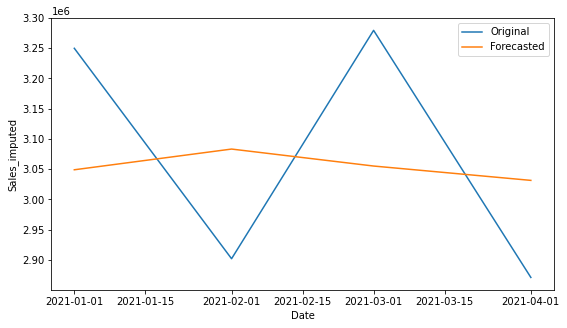

In [29]:
forecast_4mo = arima_model_fit.forecast(4, exog=df_dk_test_sales_per_month['Quarter'])

plt.figure(figsize=(9,5))
sns.lineplot(x='Date', y='Sales_imputed', data=df_dk_test_sales_per_month_indexed, label='Original')
sns.lineplot(x=df_dk_test_sales_per_month_indexed.index, y=forecast_4mo.values, label='Forecasted')

In [30]:
f = forecast_4mo.values
a = df_dk_test_sales_per_month['Sales_imputed'].values
print('RMSE:', math.sqrt(sum((a-f)**2)))

RMSE: 386791.7560322135


Based on 2 models above, ARIMA with exogenous variable has a better performance with smaller RMSE. Therefore, I will use it to forecast future sales (until the end of year 2021).

<AxesSubplot:>

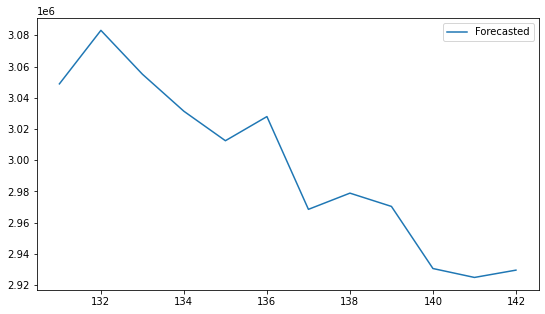

In [31]:
forecast_exog = [1,1,1,2,2,2,3,3,3,4,4,4]
forecast_30mil = arima_model_fit.forecast(12, exog=forecast_exog)
plt.figure(figsize=(9,5))
# sns.lineplot(x='Date', y='Sales', data=df_dk_test_sales_per_month_indexed, label='Original')
sns.lineplot(x=forecast_30mil.index, y=forecast_30mil.values, label='Forecasted')

In [32]:
total_sales_2021 = pd.concat((df_dk_test_sales_per_month['Sales_imputed'], forecast_30mil.iloc[len(df_dk_test_sales_per_month):])).reset_index()
total_sales_2021 = total_sales_2021.rename(columns={0: 'Sales'})
total_sales_2021['Cumulative_sum'] = total_sales_2021['Sales'].cumsum()
total_sales_2021

,index,Sales,Cumulative_sum
0,0,3.249935e+06,3.249935e+06
1,1,2.901658e+06,6.151593e+06
2,2,3.279624e+06,9.431217e+06
3,3,2.870671e+06,1.230189e+07
4,135,3.012452e+06,1.531434e+07
5,136,3.027916e+06,1.834226e+07
6,137,2.968478e+06,2.131073e+07
7,138,2.978863e+06,2.428960e+07
8,139,2.970353e+06,2.725995e+07
9,140,2.930561e+06,3.019051e+07


Based on the model's prediction, Denki Kobo will achieve a total of 30 million goods sold on October 2021 (predicted around 30.19 million goods sold).